## <div style="text-align: center"> Binary Classification of Machine Failures </div>
### <div style="text-align: center"> Playground Series - Season 3, Episode 17 </div>
---

## 📂 Data

<center>

| Filename | Description |
| - | - |
| train.csv |  the training dataset; Machine failure is the (binary) target (which, in order to align with the ordering of the original dataset, **is not in the last column position)** |
| test.csv | the test dataset; your objective is to predict the probability of Machine failure |
| sample_submission.csv | a sample submission file in the correct format |

</center>


# 0 | ⚙ setup

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)


In [2]:
is_kaggle = False

data_dir = Path(
    "/kaggle/input/playground-series-s3e17" if is_kaggle else "../data/"
)
train_data_path = data_dir / "train.csv"
test_data_path = data_dir / "test.csv"
submission_data_path = data_dir / "sample_submission.csv"

test_size = 0.3
random_state = 1


# 1 | 📂 load train data

In [3]:
data = pd.read_csv(train_data_path)

feature_cols = [
    "Type",
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "TWF",
    "HDF",
    "PWF",
    "OSF",
    "RNF"
]

target_col = "Machine failure"
target = data.pop(target_col)

display(data)


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0


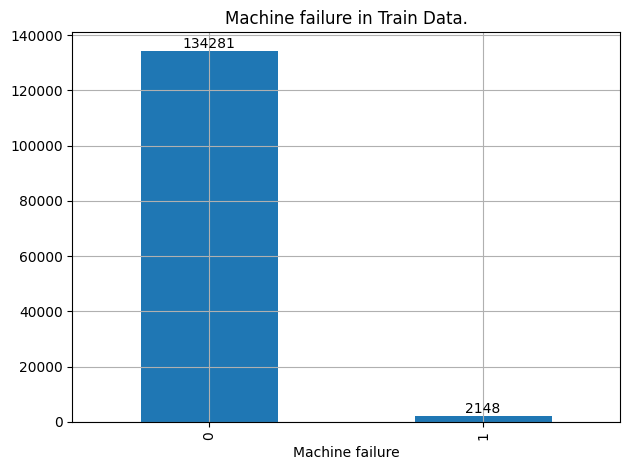

In [4]:
# Check the number of Machine failure in training data.

fig, ax = plt.subplots(1, 1)
target.value_counts().plot(ax=ax, kind="bar")
for bars in ax.containers:
    ax.bar_label(bars)

ax.set_title("Machine failure in Train Data.")
ax.grid()
fig.tight_layout()
plt.close()

display(fig)


# 2 | 📚 Make training dataset...

In [5]:
# Set features categories
numeric_feats = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
]

categorical_feats = [
    "TWF",
    "HDF",
    "PWF",
    "OSF",
    "RNF"
]

# Need one-hot-encoding this columns
onehot_feat = [
    "Type"
]


In [6]:
# Split training and validation.
train_idx, valid_idx = train_test_split(
    data.index,
    test_size=test_size,
    random_state=random_state,
    shuffle=True,
    stratify=target
)

train_X, train_y = data.loc[train_idx, feature_cols], target[train_idx]
valid_X, valid_y = data.loc[valid_idx, feature_cols], target[valid_idx]


In [7]:
# Calculate class weights from the number of machine failure in the train data.
class_weights = abs(1 - train_y.value_counts() / train_y.shape[0]).to_dict()


# 3 | 🔨 Make Classifier Pipeline.

In [8]:
# make piplines

# use models
svm = SVC(
    kernel="rbf",
    class_weight=class_weights,
    verbose=True,
    random_state=random_state
)

randomforest = RandomForestClassifier(
    class_weight=class_weights,
    verbose=True,
    random_state=random_state
)

hgbdt = HistGradientBoostingClassifier(
    class_weight=class_weights,
    verbose=True,
    random_state=random_state
)

# base preprocessor pipline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric',  StandardScaler(), numeric_feats),
        ('type_of_one-hot', OneHotEncoder(handle_unknown='ignore'), onehot_feat),

    ],
    remainder="passthrough"
)

# models piplines
svm_pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("SVM", svm)
    ]
)

hgbdt_pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("HistGradientBoosting", hgbdt)
    ]
)

randomforest_pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("RandomForest", randomforest)
    ]
)


In [9]:
# Stacking all models.
stacking_classifier = StackingClassifier(
    estimators=[
        ("SVM", svm_pipeline),
        ("HistGradientBoosting", hgbdt_pipeline),
        ("Random Forest", randomforest_pipeline),
    ],
    final_estimator=LogisticRegression()
)
display(stacking_classifier)


StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('Preprocessor',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('numeric',
                                                                                  StandardScaler(),
                                                                                  ['Air '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torque '
                                                                                   '[Nm]',
                                                                                   'Tool '
                                                                                   'wear '
                                                                                   '[min]']),
                                                                                 ('type_of_one-hot',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['Type'])])),
                                                ('SVM',
                                                 S...
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torque '
                                                                                   '[Nm]',
                                                                                   'Tool '
                                                                                   'wear '
                                                                                   '[min]']),
                                                                                 ('type_of_one-hot',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['Type'])])),
                                                ('RandomForest',
                                                 RandomForestClassifier(class_weight={0: 0.01574869109947641,
                                                                                      1: 0.9842513089005236},
                                                                  

# 4 | 🤖 Train Classifier.

In [10]:
stacking_classifier.fit(train_X, train_y)


[LibSVM]Binning 0.009 GB of training data: 0.043 s
Binning 0.001 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.62139, val loss: 0.62790, in 0.023s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.56227, val loss: 0.57442, in 0.023s
[3/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.51303, val loss: 0.53030, in 0.022s
[4/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.47124, val loss: 0.49270, in 0.022s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.43559, val loss: 0.46035, in 0.023s
[6/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.40497, val loss: 0.43286, in 0.023s
[7/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.37786, val loss: 0.41034, in 0.023s
[8/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.35419, val loss: 0.39073, in 0.024s
[9/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.33341, val loss: 0.37389, in 0.024s
[10/100] 1 tree, 31 leaves, max de

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Binning 0.007 GB of training data: 0.025 s
Binning 0.001 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.62134, val loss: 0.61991, in 0.012s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.56250, val loss: 0.55950, in 0.011s
[3/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.51316, val loss: 0.50837, in 0.010s
[4/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.47163, val loss: 0.46648, in 0.009s
[5/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.43627, val loss: 0.43047, in 0.010s
[6/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.40575, val loss: 0.39964, in 0.010s
[7/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.37910, val loss: 0.37312, in 0.009s
[8/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.35571, val loss: 0.35049, in 0.008s
[9/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.33539, val loss: 0.33089, in 0.010s
[1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

StackingClassifier(estimators=[('SVM',
                                Pipeline(steps=[('Preprocessor',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('numeric',
                                                                                  StandardScaler(),
                                                                                  ['Air '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torque '
                                                                                   '[Nm]',
                                                                                   'Tool '
                                                                                   'wear '
                                                                                   '[min]']),
                                                                                 ('type_of_one-hot',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['Type'])])),
                                                ('SVM',
                                                 S...
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Process '
                                                                                   'temperature '
                                                                                   '[K]',
                                                                                   'Rotational '
                                                                                   'speed '
                                                                                   '[rpm]',
                                                                                   'Torque '
                                                                                   '[Nm]',
                                                                                   'Tool '
                                                                                   'wear '
                                                                                   '[min]']),
                                                                                 ('type_of_one-hot',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['Type'])])),
                                                ('RandomForest',
                                                 RandomForestClassifier(class_weight={0: 0.01574869109947641,
                                                                                      1: 0.9842513089005236},
                                                                  

# 5 | 🧑‍⚖️ Evaluate Classifier

In [11]:
def plot_confusion_matrix(
    true_y,
    pred_y,
    labels=None,
    ax=None,
    fontsize=13,
    cmap="Blues",
    heatmap_kws=dict()
):
    cm = pd.DataFrame(
        confusion_matrix(true_y, pred_y),
        index=labels,
        columns=labels,

    )

    sns.heatmap(
        cm,
        ax=ax,
        square=True,
        annot=True,
        cbar=True,
        linewidth=2.0,
        fmt="d",
        cmap=cmap,
        ** heatmap_kws
    )

    ax.set_ylim(len(cm), 0)
    ax.set_xlabel("Predict", fontsize=fontsize, rotation=0)
    ax.set_ylabel("Actual", fontsize=fontsize)

    return ax


def plot_classification_report(cr: pd.DataFrame, ax=None, labelsize=13):

    sns.heatmap(
        cr.iloc[:-2, :],
        vmin=0.0,
        vmax=1.0,
        cmap=sns.color_palette("Blues", 24),
        fmt='0.4g',
        linewidth=2.0,
        annot=True,
        annot_kws=dict(size=14),
        ax=ax,
    )
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    return ax


def edit_classification_report(cr: pd.DataFrame):
    supports = ('\n(' + cr.iloc[:-3, -1].astype(int).astype(str) + ')')
    cr.index = (cr.index[:-3] + supports).to_list() + cr.index[-3:].to_list()
    cr = cr.iloc[:, :-1].copy()
    cr.iloc[-3:, :-1] = np.nan
    return cr


In [12]:
pred_y = stacking_classifier.predict(valid_X)

report = edit_classification_report(
    pd.DataFrame(
        classification_report(
            valid_y,
            pred_y,
            output_dict=True,
        )
    ).transpose()
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


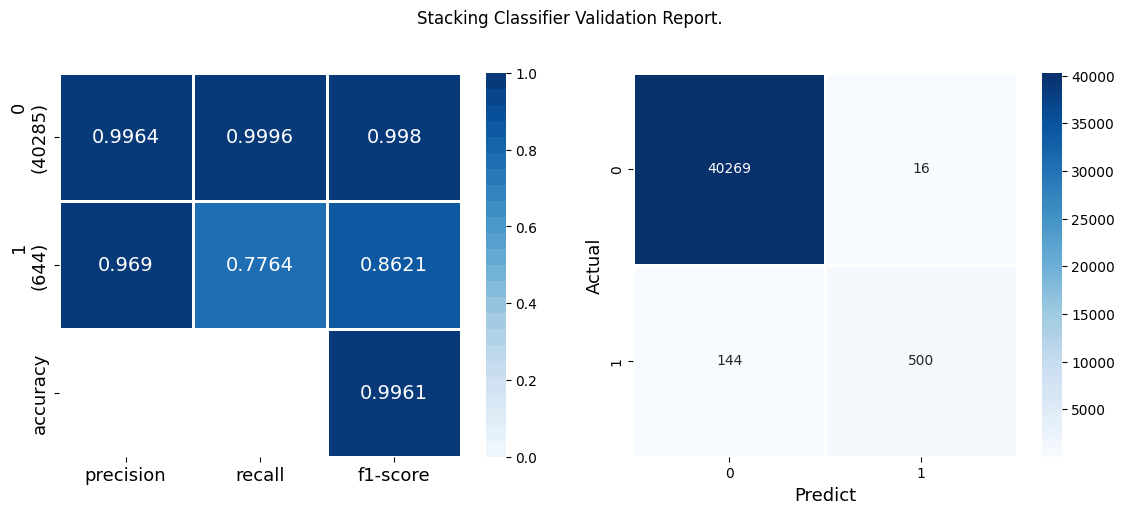

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(11.5, 5))
fig.suptitle("Stacking Classifier Validation Report.")
plot_classification_report(report, ax=axes[0])
plot_confusion_matrix(valid_y, pred_y, ax=axes[1])
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.close()

display(fig)


# 6 | 📤 Submission

In [14]:
# make submission file
test_data = pd.read_csv(test_data_path)
test_proba = stacking_classifier.predict_proba(test_data)

sub = pd.read_csv(submission_data_path)
sub["Machine failure"] = test_proba[:, 1]
sub.to_csv("submission.csv", index=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


---